In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ratikkakkar/electric-vehicle-population-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/electric-vehicle-population-data


# Forecasting

Data shape: (112634, 17)
Columns:
 Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

Missing values per column:
 VIN (1-10)                                             0
County                                                 0
City                                                   0
State                                                  0
Postal Code                                            0
Model Year                                             0
Make                                                   0
Model                                                 20
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric 

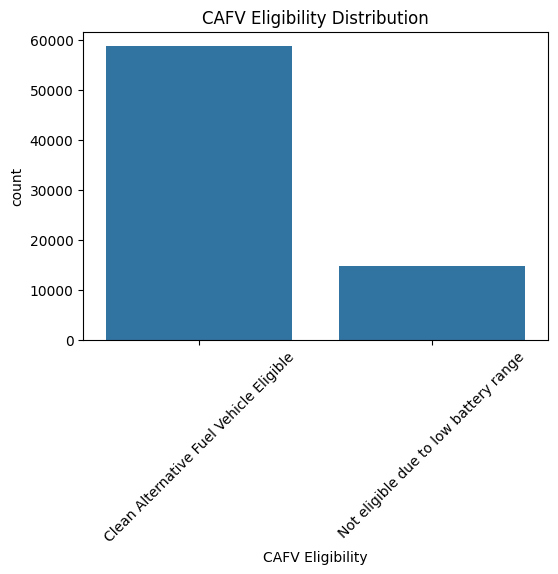

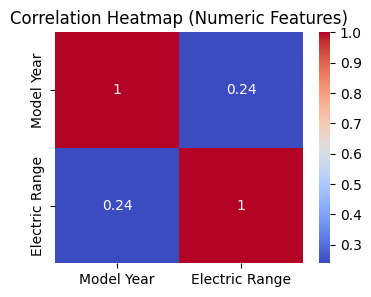


--- Random Forest ---
Accuracy:  0.9913
Precision: 0.9866
Recall:    0.9702
F1 Score:  0.9783
              precision    recall  f1-score   support

Not eligible       0.99      1.00      0.99     11728
    Eligible       0.99      0.97      0.98      2952

    accuracy                           0.99     14680
   macro avg       0.99      0.98      0.99     14680
weighted avg       0.99      0.99      0.99     14680



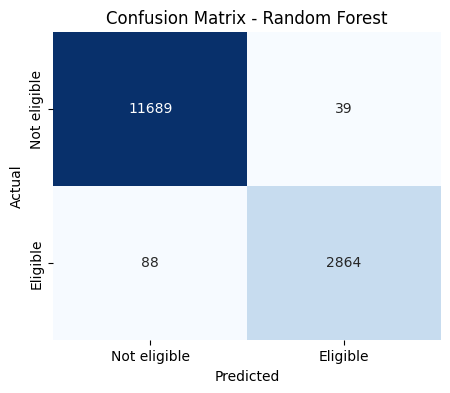


--- Decision Tree ---
Accuracy:  0.9913
Precision: 0.9862
Recall:    0.9702
F1 Score:  0.9781
              precision    recall  f1-score   support

Not eligible       0.99      1.00      0.99     11728
    Eligible       0.99      0.97      0.98      2952

    accuracy                           0.99     14680
   macro avg       0.99      0.98      0.99     14680
weighted avg       0.99      0.99      0.99     14680



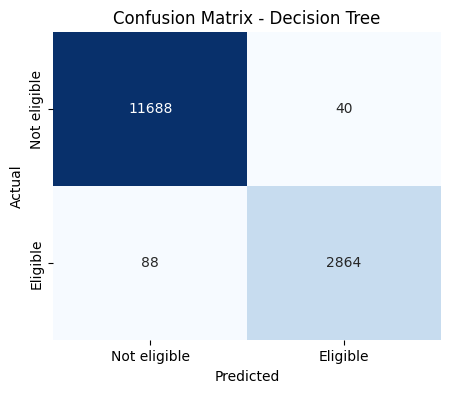


--- SVM ---
Accuracy:  0.9655
Precision: 0.9463
Recall:    0.8780
F1 Score:  0.9109
              precision    recall  f1-score   support

Not eligible       0.97      0.99      0.98     11728
    Eligible       0.95      0.88      0.91      2952

    accuracy                           0.97     14680
   macro avg       0.96      0.93      0.94     14680
weighted avg       0.97      0.97      0.96     14680



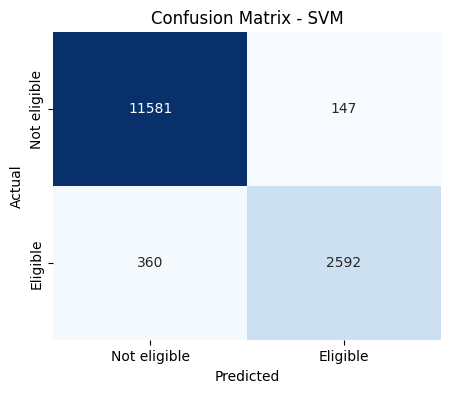


--- XGBoost ---
Accuracy:  0.9913
Precision: 0.9866
Recall:    0.9702
F1 Score:  0.9783
              precision    recall  f1-score   support

Not eligible       0.99      1.00      0.99     11728
    Eligible       0.99      0.97      0.98      2952

    accuracy                           0.99     14680
   macro avg       0.99      0.98      0.99     14680
weighted avg       0.99      0.99      0.99     14680



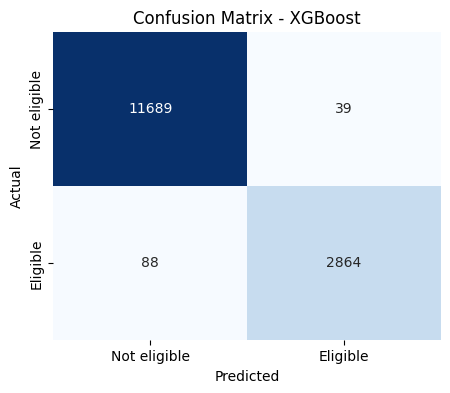

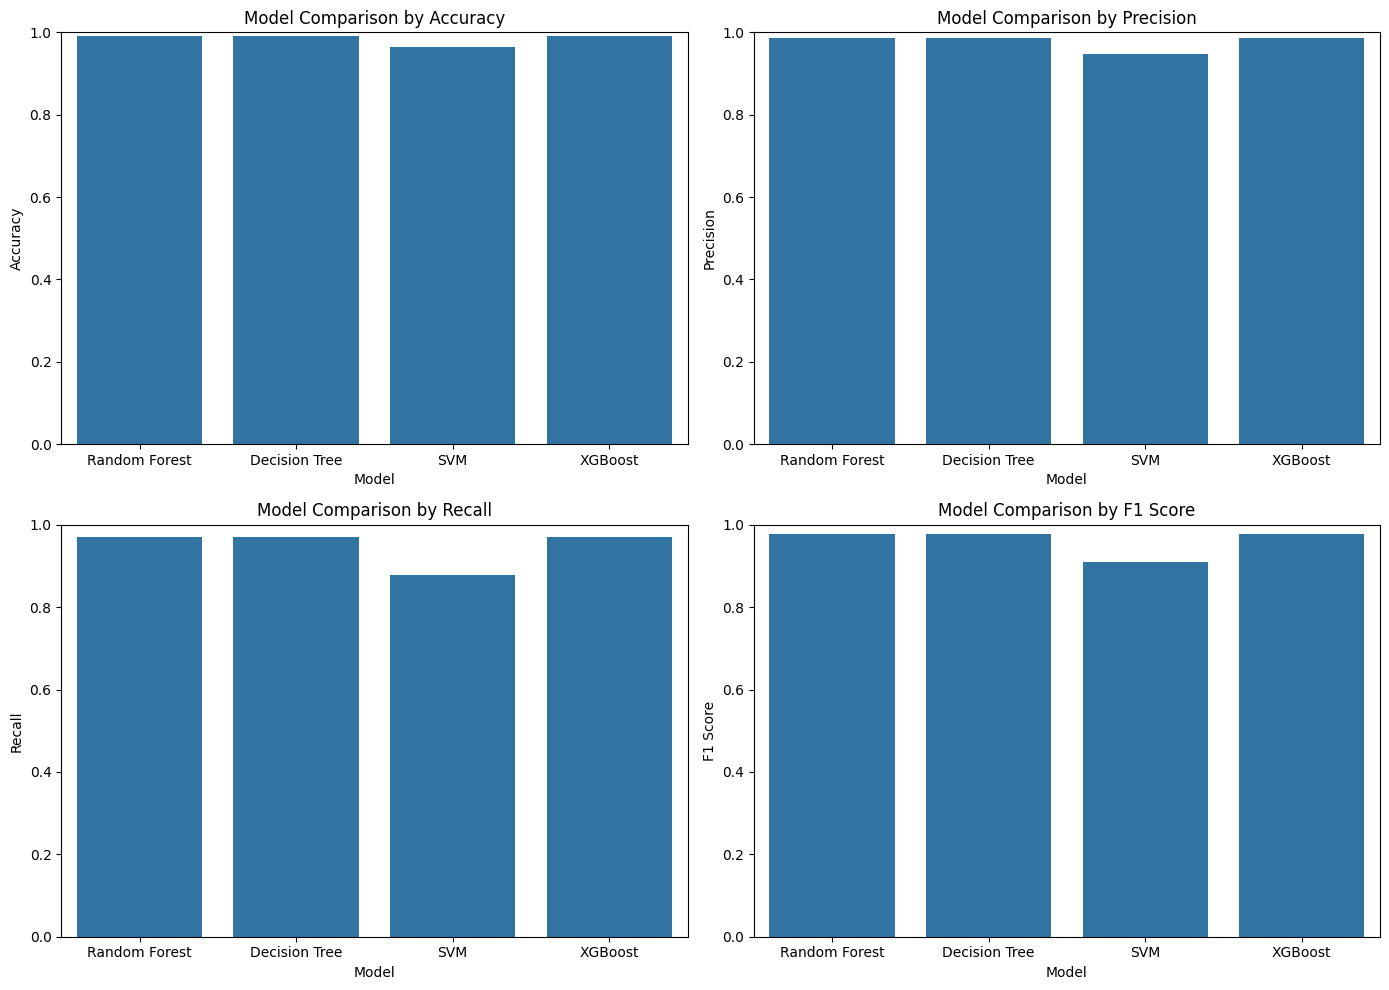

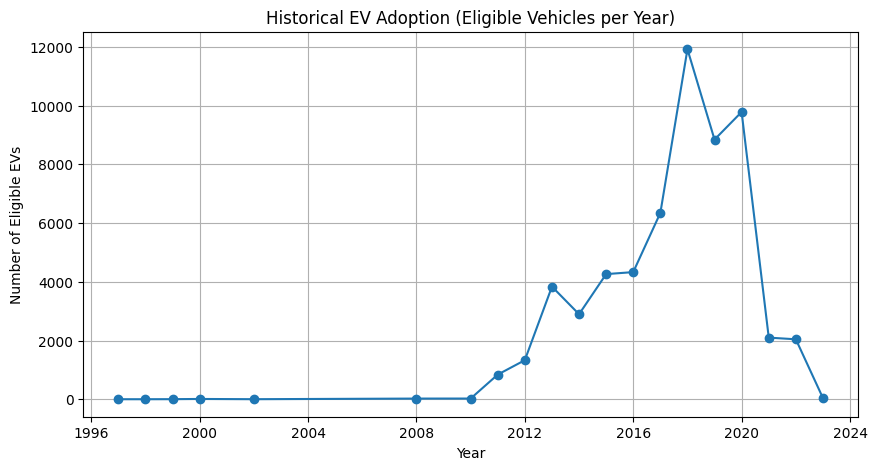

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsjxp_5a3/tabdqwub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsjxp_5a3/4gbmv3sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82345', 'data', 'file=/tmp/tmpsjxp_5a3/tabdqwub.json', 'init=/tmp/tmpsjxp_5a3/4gbmv3sy.json', 'output', 'file=/tmp/tmpsjxp_5a3/prophet_model5jat45yo/prophet_model-20250623144215.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:42:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


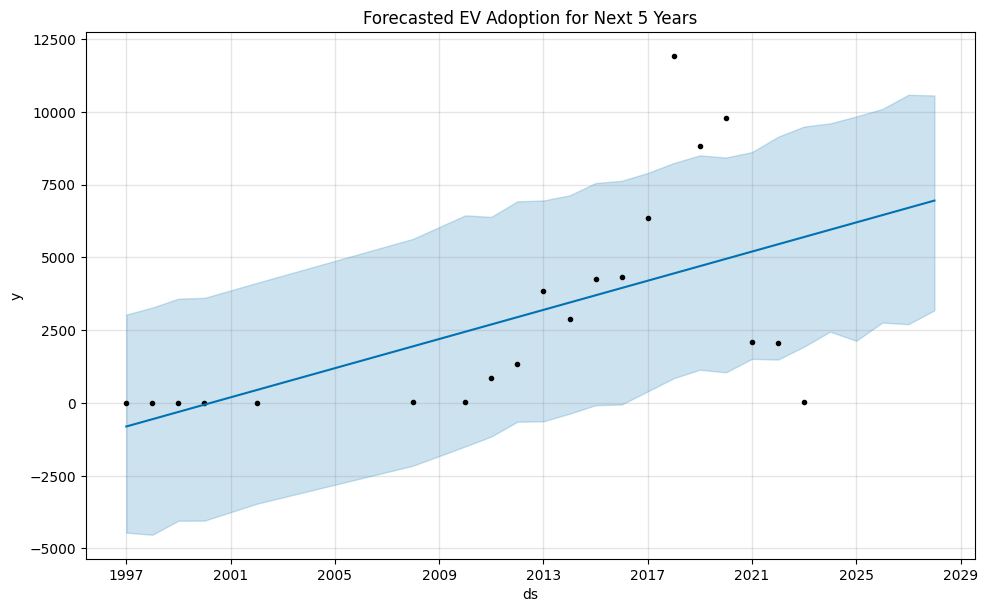

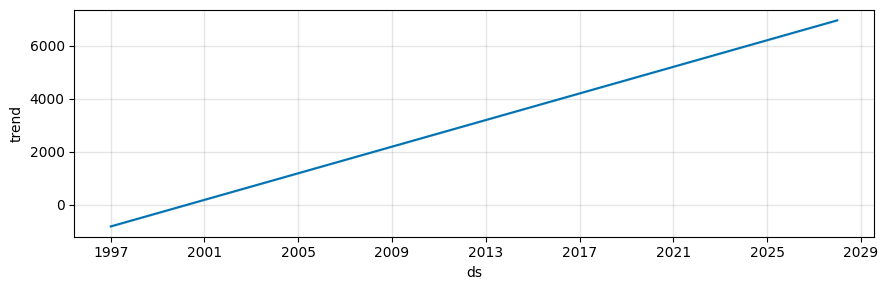

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from prophet import Prophet
import warnings

warnings.filterwarnings("ignore")

# --- Load Data ---
df = pd.read_csv("/kaggle/input/electric-vehicle-population-data/Electric_Vehicle_Population_Data.csv")

# --- EDA ---
print("Data shape:", df.shape)
print("Columns:\n", df.columns)
print("\nMissing values per column:\n", df.isna().sum())
print("\nValue counts for CAFV Eligibility:\n", df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts())

# Rename for ease of use
df.rename(columns={'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'CAFV Eligibility'}, inplace=True)

# Drop rows with missing key info
df.dropna(subset=['CAFV Eligibility', 'Make', 'Model', 'Model Year', 'Electric Vehicle Type'], inplace=True)

# Filter relevant eligibility classes
df = df[df['CAFV Eligibility'].isin(['Clean Alternative Fuel Vehicle Eligible', 'Not eligible due to low battery range'])]

# Plot eligibility distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='CAFV Eligibility')
plt.title("CAFV Eligibility Distribution")
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap for numeric columns
corr_cols = ['Model Year', 'Electric Range']
corr = df[corr_cols].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# --- Encoding categorical variables ---
label_encoders = {}
for col in ['Make', 'Model', 'Electric Vehicle Type', 'CAFV Eligibility']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature and target selection
features = ['Make', 'Model', 'Model Year']
target = 'CAFV Eligibility'
X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# Prepare results dict
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results['Model'].append(name)
    results['Accuracy'].append(acc)
    results['Precision'].append(prec)
    results['Recall'].append(rec)
    results['F1 Score'].append(f1)

    print(f"\n--- {name} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Not eligible', 'Eligible']))

    # Plot separate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not eligible', 'Eligible'],
                yticklabels=['Not eligible', 'Eligible'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot comparison bar charts
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.ylim(0, 1)
    plt.title(f'Model Comparison by {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

# --- Forecasting EV Adoption with Prophet ---

# Decode eligibility to binary 1 (eligible) or 0 (not)
eligible_label = label_encoders['CAFV Eligibility'].transform(['Clean Alternative Fuel Vehicle Eligible'])[0]
df['Eligible_binary'] = (df['CAFV Eligibility'] == eligible_label).astype(int)

# Aggregate eligible EV counts per Model Year
adoption_counts = df.groupby('Model Year')['Eligible_binary'].sum().reset_index()

# Rename columns for Prophet
adoption_counts.rename(columns={'Model Year': 'ds', 'Eligible_binary': 'y'}, inplace=True)

# Convert 'ds' to datetime format (use Jan 1st for each year)
adoption_counts['ds'] = pd.to_datetime(adoption_counts['ds'], format='%Y')

# Plot historical adoption
plt.figure(figsize=(10, 5))
plt.plot(adoption_counts['ds'], adoption_counts['y'], marker='o')
plt.title("Historical EV Adoption (Eligible Vehicles per Year)")
plt.xlabel("Year")
plt.ylabel("Number of Eligible EVs")
plt.grid(True)
plt.show()

# Fit Prophet model
model = Prophet(yearly_seasonality=False, daily_seasonality=False)
model.fit(adoption_counts)

# Predict next 5 years
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Forecasted EV Adoption for Next 5 Years")
plt.show()

# Plot forecast components (trend)
model.plot_components(forecast)
plt.show()
